# ICE Membership Inference Experiments

In [1]:
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import logging

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
threads = 15

logging.basicConfig()

logger = logging.getLogger('xai-privacy')

In [3]:
from experiment_setup import run_all_experiments
from experiment_setup import get_heart_disease_dataset
from experiment_setup import get_census_dataset

In [4]:
DATASET_HALF = False

data_heart_dict, data_heart_num_dict, data_heart_cat_dict = get_heart_disease_dataset(halve_dataset=DATASET_HALF)
data_census_dict, data_census_num_dict, data_census_cat_dict = get_census_dataset(halve_dataset=DATASET_HALF)

data_heart = data_heart_dict['dataset']
outcome_name_heart = data_heart_dict['outcome']
numeric_features_heart = data_heart_dict['num']

Feature Age: removed 0 rows for missing values.
Feature RestingBP: removed 59 rows for missing values.
Feature Cholesterol: removed 27 rows for missing values.
Feature FastingBS: add unknown category 2.0
Feature RestingECG: add unknown category 3.0
Feature MaxHR: removed 0 rows for missing values.
Feature Oldpeak: removed 7 rows for missing values.
Feature ST_Slope: add unknown category 4.0
Feature CA: add unknown category 4.0
Feature Thal: add unknown category 8.0
Dropped 271 of 1097
Dropped 273 of 1097
Dropped 277 of 1097
Dropped: 2399 of 32561
census: Dropped 3848 of 30162
num: Dropped 19859 of 30162
cat: Dropped 12136 of 30162


This notebook will go through the experiment for membership inference with individual conditional expectation (ICE). Membership inference means an attacker with access to the explanation can tell with high confidence for any sample whether it was included in the training data or not.

The idea for ICE membership inference is as follows: The attacker can recreate the ICE lines for any sample and check whether they occur in the given explanation. If they do, there is a high chance that the sample was used in the training data (which was also used to create the ICE explanation). Otherwise the sample was not included in the training data.

First, we implement the `train_explainer` and `membership_inference_attack_model_access` functions:

In [5]:
# Attack code must be imported so that multiprocessing pool works. Check out ice_attack.py for the implementation of the attack.
from ice_attack import IceMembershipInference

# Executing Membership Inference

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for membership inference.

The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

In [6]:
# Train a random forest model on training data.
features = data_heart.drop(outcome_name_heart, axis=1)
labels = data_heart[outcome_name_heart]

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

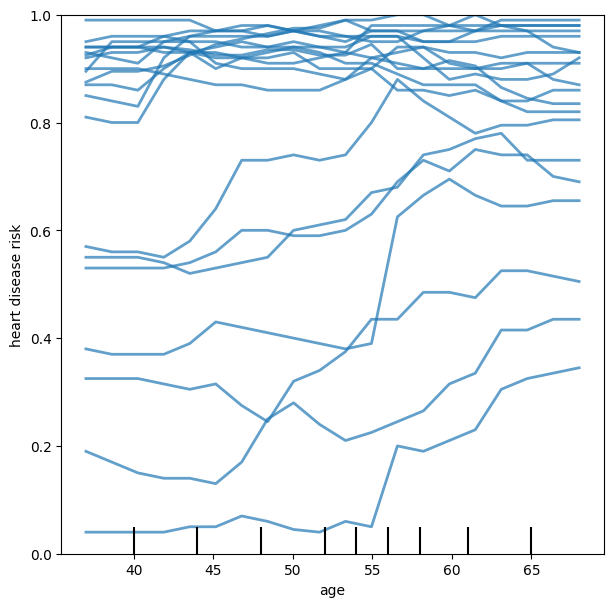

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

display = PartialDependenceDisplay.from_estimator(
       estimator=model, X=features, features=[0], feature_names=['age'], kind="individual", subsample=20,
       n_jobs=3, ice_lines_kw = { 'alpha' : 0.7, 'linewidth' : 2.0 }, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

plt.ylabel("heart disease risk")
plt.xlabel("age")

plt.show()

As a proof of concept for our privacy attack, we run the experiment with a very small amount of repetitions with logging to show that the membership inference function works in principle.

In [8]:
logger.setLevel(logging.DEBUG)

EXP = IceMembershipInference(data_heart, numeric_features_heart, outcome_name_heart, random_state=0)
EXP.membership_inference_experiment(num_queries=8, model=es.RandomForestClassifier(random_state=0), model_access=True, threads=1)

logger.setLevel(logging.INFO)

DEBUG:xai-privacy:Numeric Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
DEBUG:xai-privacy:Categorical Features: ['CA', 'ChestPainType', 'ExerciseAngina', 'FastingBS', 'RestingECG', 'ST_Slope', 'Sex', 'Thal']
DEBUG:xai-privacy:Removed 4 test samples due to unknown category.
DEBUG:xai-privacy:Calculating ICE for feature 0
DEBUG:xai-privacy:Calculating ICE for feature 1
DEBUG:xai-privacy:Calculating ICE for feature 2
DEBUG:xai-privacy:Calculating ICE for feature 3
DEBUG:xai-privacy:Calculating ICE for feature 4
DEBUG:xai-privacy:Calculating ICE for feature 5
DEBUG:xai-privacy:Calculating ICE for feature 6
DEBUG:xai-privacy:Calculating ICE for feature 7
DEBUG:xai-privacy:Calculating ICE for feature 8
DEBUG:xai-privacy:Calculating ICE for feature 9
DEBUG:xai-privacy:Calculating ICE for feature 10
DEBUG:xai-privacy:Calculating ICE for feature 11
DEBUG:xai-privacy:Calculating ICE for feature 12
DEBUG:xai-privacy:[[ 41.   1.   2. 120. 291.   0.   1. 160.   0.   0.   4.   4.

Total time: 3.91s (training model: 0.08s, training explainer: 3.29s, experiment: 0.54s)
Accuracy: 1.0, precision: 1.0, recall: 1.0


The proof of concept should show that the membership inference function predicts membership very accurately. You can change the random state to try out a few different runs with different chosen samples.

Now we begin executing the actual experiment. We begin by defining the table that will hold the results for all our different experiment variations. Then we execute all variations of the experiment for this dataset. We vary the model between a decision tree, a random forest and a neural network. Each model uses the default configuration of scikit-learn.

In [9]:
dataset_dicts = [data_heart_dict, data_heart_num_dict, data_heart_cat_dict, data_census_dict, data_census_num_dict, data_census_cat_dict]

dt_dict = {'name': 'decision tree', 'model': DecisionTreeClassifier}
rf_dict = {'name': 'random forest', 'model': es.RandomForestClassifier}
nn_dict = {'name': 'neural network', 'model': MLPClassifier}

model_dicts = [dt_dict, rf_dict, nn_dict]

In [ ]:
# This will run the experiment for each dataset and model combination

results = run_all_experiments(IceMembershipInference, dataset_dicts, model_dicts, random_state=0, num_queries=None, model_access=True, threads=threads, repeat=10)

dataset: heart, model: decision tree (repetition 0)
Total time: 11.36s (training model: 0.01s, training explainer: 2.12s, experiment: 9.23s)
Accuracy: 0.5170316301703163, precision: 0.5098765432098765, recall: 1.0
dataset: heart, model: decision tree (repetition 1)
Total time: 11.72s (training model: 0.00s, training explainer: 1.83s, experiment: 9.89s)
Accuracy: 0.5061124694376528, precision: 0.5055079559363526, recall: 1.0
dataset: heart, model: decision tree (repetition 2)
Total time: 10.45s (training model: 0.01s, training explainer: 1.40s, experiment: 9.03s)
Accuracy: 0.5134803921568627, precision: 0.5098765432098765, recall: 1.0
dataset: heart, model: decision tree (repetition 3)
Total time: 10.51s (training model: 0.01s, training explainer: 1.45s, experiment: 9.05s)
Accuracy: 0.5054945054945055, precision: 0.5048899755501223, recall: 1.0
dataset: heart, model: decision tree (repetition 4)
Total time: 10.54s (training model: 0.02s, training explainer: 1.45s, experiment: 9.08s)
Acc

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.56s (training model: 1.01s, training explainer: 2.29s, experiment: 7.26s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.62s (training model: 0.99s, training explainer: 2.25s, experiment: 7.38s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.62s (training model: 0.99s, training explainer: 2.26s, experiment: 7.37s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.58s (training model: 0.99s, training explainer: 2.24s, experiment: 7.35s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.60s (training model: 0.98s, training explainer: 2.23s, experiment: 7.39s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.80s (training model: 1.00s, training explainer: 2.28s, experiment: 7.52s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.59s (training model: 0.99s, training explainer: 2.24s, experiment: 7.36s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.59s (training model: 1.00s, training explainer: 2.26s, experiment: 7.33s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.58s (training model: 0.99s, training explainer: 2.25s, experiment: 7.34s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 10.62s (training model: 0.98s, training explainer: 2.24s, experiment: 7.40s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 0)
Total time: 4.65s (training model: 0.00s, training explainer: 0.59s, experiment: 4.06s)
Accuracy: 0.5183374083129584, precision: 0.511166253101737, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 1)
Total time: 4.69s (training model: 0.01s, training explainer: 0.67s, experiment: 4.01s)
Accuracy: 0.536019536019536, precision: 0.5202020202020202, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 2)
Total time: 4.74s (training model: 0.02s, training explainer: 0.71s, experiment: 4.01s)
Accuracy: 0.5245098039215687, precision: 0.515, recall: 1.0
dataset: heart numeric, model: decision tree (repetition 3)
Total time: 4.68s (training model: 0.01s, training explainer: 0.67s, experiment: 4.01s)
Accuracy: 0.5339925834363412, precision: 0.5221799746514575, recall: 1.0

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.37s (training model: 0.54s, training explainer: 1.05s, experiment: 3.78s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 1)
Total time: 5.30s (training model: 0.56s, training explainer: 1.00s, experiment: 3.74s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.36s (training model: 0.55s, training explainer: 1.00s, experiment: 3.80s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.37s (training model: 0.61s, training explainer: 1.00s, experiment: 3.76s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.31s (training model: 0.57s, training explainer: 1.00s, experiment: 3.74s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.31s (training model: 0.57s, training explainer: 1.02s, experiment: 3.73s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.24s (training model: 0.53s, training explainer: 0.95s, experiment: 3.75s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.25s (training model: 0.54s, training explainer: 0.99s, experiment: 3.72s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.30s (training model: 0.60s, training explainer: 1.00s, experiment: 3.71s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 5.24s (training model: 0.55s, training explainer: 0.97s, experiment: 3.73s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 0)
Total time: 8.31s (training model: 0.01s, training explainer: 0.27s, experiment: 8.03s)
Accuracy: 0.5123152709359606, precision: 0.5086848635235732, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 1)
Total time: 8.35s (training model: 0.00s, training explainer: 0.30s, experiment: 8.05s)
Accuracy: 0.5134474327628362, precision: 0.5074257425742574, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 2)
Total time: 8.40s (training model: 0.00s, training explainer: 0.31s, experiment: 8.08s)
Accuracy: 0.5061425061425061, precision: 0.5049261083743842, recall: 1.0
dataset: heart categorical, model: decision tree (repetition 3)
Total time: 8.42s (training model: 0.01s, training explainer: 0.28s, experiment: 8.13s)
Accuracy: 0.508578431372549, precision: 0.

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 17.19s (training model: 0.16s, training explainer: 1.00s, experiment: 16.03s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 16.55s (training model: 0.14s, training explainer: 0.99s, experiment: 15.42s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 16.58s (training model: 0.14s, training explainer: 0.98s, experiment: 15.46s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 16.78s (training model: 0.12s, training explainer: 1.02s, experiment: 15.64s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 17.21s (training model: 0.13s, training explainer: 1.06s, experiment: 16.03s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 17.31s (training model: 0.14s, training explainer: 1.00s, experiment: 16.16s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 16.54s (training model: 0.12s, training explainer: 0.99s, experiment: 15.43s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 16.81s (training model: 0.14s, training explainer: 1.02s, experiment: 15.65s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 17.03s (training model: 0.12s, training explainer: 1.04s, experiment: 15.87s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 17.08s (training model: 0.13s, training explainer: 1.01s, experiment: 15.94s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.13s (training model: 0.91s, training explainer: 0.36s, experiment: 5.86s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.12s (training model: 0.91s, training explainer: 0.38s, experiment: 5.83s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.10s (training model: 0.89s, training explainer: 0.38s, experiment: 5.83s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.10s (training model: 0.88s, training explainer: 0.37s, experiment: 5.85s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.21s (training model: 0.84s, training explainer: 0.41s, experiment: 5.96s)
Accuracy: 0.99265605875153, precision: 0.9855769230769231, recall: 1.0
dataset: heart categorical, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.16s (training model: 0.88s, training explainer: 0.38s, experiment: 5.91s)
Accuracy: 0.992619926199262, precision: 0.9855769230769231, recall: 1.0
dataset: heart categorical, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.20s (training model: 0.88s, training explainer: 0.36s, experiment: 5.96s)
Accuracy: 0.9938574938574939, precision: 0.9879518072289156, recall: 1.0
dataset: heart categorical, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.17s (training model: 0.88s, training explainer: 0.38s, experiment: 5.91s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: heart categorical, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.04s (training model: 0.88s, training explainer: 0.36s, experiment: 5.80s)
Accuracy: 0.9987745098039216, precision: 0.9975669099756691, recall: 1.0
dataset: heart categorical, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 7.15s (training model: 0.87s, training explainer: 0.39s, experiment: 5.90s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: census, model: decision tree (repetition 0)
Total time: 1220.52s (training model: 0.32s, training explainer: 6.93s, experiment: 1213.28s)
Accuracy: 0.5399787185528616, precision: 0.520821787665268, recall: 1.0
dataset: census, model: decision tree (repetition 1)
Total time: 1210.26s (training model: 0.31s, training explainer: 6.73s, experiment: 1203.23s)
Accuracy: 0.5431742170872605, precision: 0.5225801326607618, recall: 1.0
dataset: census, model: decision tree (repetition 2)
Total time: 1217.07s (training model: 0.33s, training explainer: 6.61s, experiment: 1210.13s)
Accuracy: 0.5420134534260631, precision: 0.521937480165027, recall: 1.0
dataset: census, model: decision tree (repetition 3)
Total time: 1217.08s (training model: 0.30s, training explainer: 6.57s, experiment: 1210.21s)
Accuracy: 0.5383095165703862, precision: 0.5199367713890536, rec

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 994.48s (training model: 5.83s, training explainer: 76.30s, experiment: 912.35s)
Accuracy: 0.9865075443730759, precision: 0.9737270574304322, recall: 1.0
dataset: census, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 980.48s (training model: 6.06s, training explainer: 79.63s, experiment: 894.79s)
Accuracy: 0.9894348800972903, precision: 0.9793077781912914, recall: 1.0
dataset: census, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 984.81s (training model: 5.91s, training explainer: 77.76s, experiment: 901.13s)
Accuracy: 0.9883332066580528, precision: 0.9771984551396317, recall: 1.0
dataset: census, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 979.17s (training model: 6.01s, training explainer: 75.92s, experiment: 897.24s)
Accuracy: 0.9904609888648197, precision: 0.9812798329355609, recall: 1.0
dataset: census, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 996.25s (training model: 5.71s, training explainer: 76.51s, experiment: 914.03s)
Accuracy: 0.9861670593600365, precision: 0.9730789142814881, recall: 1.0
dataset: census, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 976.08s (training model: 5.91s, training explainer: 75.55s, experiment: 894.62s)
Accuracy: 0.9910310492912249, precision: 0.9823788546255506, recall: 1.0
dataset: census, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 981.96s (training model: 5.85s, training explainer: 76.18s, experiment: 899.93s)
Accuracy: 0.9898145332927941, precision: 0.9800372439478585, recall: 1.0
dataset: census, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 986.53s (training model: 5.92s, training explainer: 76.26s, experiment: 904.35s)
Accuracy: 0.9892448599551552, precision: 0.9789434523809524, recall: 1.0
dataset: census, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 977.68s (training model: 5.74s, training explainer: 76.00s, experiment: 895.94s)
Accuracy: 0.9853310025081705, precision: 0.9714981909473529, recall: 1.0
dataset: census, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 998.66s (training model: 6.05s, training explainer: 77.11s, experiment: 915.50s)
Accuracy: 0.982252793189937, precision: 0.9657222548443922, recall: 1.0
dataset: census, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 711.73s (training model: 27.27s, training explainer: 13.09s, experiment: 671.37s)
Accuracy: 0.9613499030897276, precision: 0.9981943532501641, recall: 0.9243748574903093
dataset: census, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 713.10s (training model: 27.19s, training explainer: 13.35s, experiment: 672.56s)
Accuracy: 0.942461900961502, precision: 0.9981175665269102, recall: 0.8866002888196397
dataset: census, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 737.23s (training model: 27.48s, training explainer: 13.31s, experiment: 696.45s)
Accuracy: 0.9985559018013225, precision: 0.9985559018013225, recall: 0.9985559018013225
dataset: census, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 716.30s (training model: 27.40s, training explainer: 13.19s, experiment: 675.71s)
Accuracy: 0.9584235929008474, precision: 0.9972792480831066, recall: 0.9193585163791138
dataset: census, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 738.85s (training model: 27.41s, training explainer: 13.24s, experiment: 698.21s)
Accuracy: 0.9995819397993311, precision: 0.9991646415552855, recall: 1.0
dataset: census, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 746.53s (training model: 27.97s, training explainer: 13.42s, experiment: 705.15s)
Accuracy: 0.9992019457323098, precision: 0.9988607018076865, recall: 0.9995439689898913
dataset: census, model: neural network (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 736.44s (training model: 27.40s, training explainer: 13.26s, experiment: 695.78s)
Accuracy: 0.9993539560690127, precision: 0.9987095794747229, recall: 1.0
dataset: census, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 736.20s (training model: 27.51s, training explainer: 13.33s, experiment: 695.36s)
Accuracy: 0.9995059476304489, precision: 0.9990129081245255, recall: 1.0
dataset: census, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 741.81s (training model: 27.49s, training explainer: 13.50s, experiment: 700.82s)
Accuracy: 0.994299395735948, precision: 0.9987729120331313, recall: 0.989815307440906
dataset: census, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 741.36s (training model: 27.13s, training explainer: 13.29s, experiment: 700.94s)
Accuracy: 0.9994679638215399, precision: 0.9989370586895452, recall: 1.0
dataset: census numeric, model: decision tree (repetition 0)
Total time: 141.93s (training model: 0.00s, training explainer: 0.89s, experiment: 141.04s)
Accuracy: 0.5266427254197806, precision: 0.513710240303121, recall: 1.0
dataset: census numeric, model: decision tree (repetition 1)
Total time: 144.14s (training model: 0.02s, training explainer: 0.95s, experiment: 143.17s)
Accuracy: 0.5302339124526837, precision: 0.5156124899919936, recall: 1.0
dataset: census numeric, model: decision tree (repetition 2)
Total time: 143.28s (training model: 0.02s, training explainer: 0.91s, experiment: 142.36s)
Accuracy: 0.5284410794020579, precision: 0.5146853146853146, recall: 1.0
dataset: census numeric, model: decision tree (repetition 3)
Total time: 144.25s (training model: 0.02s, training explainer: 0.92s, experiment: 143.31s)
Acc

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 111.05s (training model: 5.89s, training explainer: 2.73s, experiment: 102.43s)
Accuracy: 0.9859250630945448, precision: 0.9726260147253162, recall: 1.0
dataset: census numeric, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 110.65s (training model: 5.97s, training explainer: 2.70s, experiment: 101.97s)
Accuracy: 0.9865087838493642, precision: 0.9737289737289737, recall: 1.0
dataset: census numeric, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 109.81s (training model: 6.02s, training explainer: 2.66s, experiment: 101.13s)
Accuracy: 0.9791262135922331, precision: 0.9599403763741382, recall: 1.0
dataset: census numeric, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 111.24s (training model: 5.92s, training explainer: 2.76s, experiment: 102.56s)
Accuracy: 0.9828205377074638, precision: 0.966785513229499, recall: 1.0
dataset: census numeric, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 110.31s (training model: 5.90s, training explainer: 2.73s, experiment: 101.67s)
Accuracy: 0.987284022519899, precision: 0.9752034828695817, recall: 1.0
dataset: census numeric, model: neural network (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 110.55s (training model: 5.97s, training explainer: 2.65s, experiment: 101.93s)
Accuracy: 0.98534265191225, precision: 0.9715255515745804, recall: 1.0
dataset: census numeric, model: neural network (repetition 6)
Total time: 109.85s (training model: 5.15s, training explainer: 2.71s, experiment: 101.99s)
Accuracy: 0.9812675919635058, precision: 0.9638914873713751, recall: 1.0
dataset: census numeric, model: neural network (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 111.00s (training model: 5.94s, training explainer: 2.78s, experiment: 102.27s)
Accuracy: 0.9858293700863826, precision: 0.9724424311060778, recall: 1.0
dataset: census numeric, model: neural network (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 112.71s (training model: 5.98s, training explainer: 2.78s, experiment: 103.96s)
Accuracy: 0.98592642919538, precision: 0.9726260147253162, recall: 1.0
dataset: census numeric, model: neural network (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 110.40s (training model: 6.03s, training explainer: 2.73s, experiment: 101.64s)
Accuracy: 0.9841793652334272, precision: 0.9693320790216369, recall: 1.0
dataset: census categorical, model: decision tree (repetition 0)
Total time: 189.70s (training model: 0.17s, training explainer: 1.22s, experiment: 188.31s)
Accuracy: 0.516615811373093, precision: 0.5084621460002257, recall: 1.0
dataset: census categorical, model: decision tree (repetition 1)
Total time: 191.08s (training model: 0.17s, training explainer: 1.24s, experiment: 189.67s)
Accuracy: 0.511403362743466, precision: 0.5058367942530025, recall: 1.0
dataset: census categorical, model: decision tree (repetition 2)
Total time: 187.22s (training model: 0.19s, training explainer: 1.22s, experiment: 185.81s)
Accuracy: 0.5139258766089658, precision: 0.5070890064138629, recall: 1.0
dataset: census categorical, model: decision tree (repetition 3)
Total time: 196.94s (training model: 0.17s, training explainer: 1.19s, experiment:

c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 366.72s (training model: 3.95s, training explainer: 20.41s, experiment: 342.37s)
Accuracy: 0.9998890245255798, precision: 0.9997781475318913, recall: 1.0
dataset: census categorical, model: random forest (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 367.91s (training model: 3.75s, training explainer: 20.49s, experiment: 343.66s)
Accuracy: 0.9999445184198846, precision: 0.9998890614599512, recall: 1.0
dataset: census categorical, model: random forest (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 365.45s (training model: 3.97s, training explainer: 20.59s, experiment: 340.89s)
Accuracy: 0.9997780613660323, precision: 0.9995563934789842, recall: 1.0
dataset: census categorical, model: random forest (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 370.87s (training model: 3.90s, training explainer: 20.64s, experiment: 346.33s)
Accuracy: 0.999778098302452, precision: 0.9995563934789842, recall: 1.0
dataset: census categorical, model: random forest (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 367.02s (training model: 3.95s, training explainer: 20.55s, experiment: 342.52s)
Accuracy: 0.9996670551023805, precision: 0.9993347377758066, recall: 1.0
dataset: census categorical, model: random forest (repetition 5)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 379.19s (training model: 3.94s, training explainer: 20.99s, experiment: 354.26s)
Accuracy: 1.0, precision: 1.0, recall: 1.0
dataset: census categorical, model: random forest (repetition 6)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 367.12s (training model: 3.97s, training explainer: 20.91s, experiment: 342.23s)
Accuracy: 0.999889049151226, precision: 0.9997781475318913, recall: 1.0
dataset: census categorical, model: random forest (repetition 7)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 372.74s (training model: 3.88s, training explainer: 20.05s, experiment: 348.81s)
Accuracy: 0.9998335552596538, precision: 0.9996672582076309, recall: 1.0
dataset: census categorical, model: random forest (repetition 8)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 375.30s (training model: 3.97s, training explainer: 20.26s, experiment: 351.07s)
Accuracy: 0.9997780367349204, precision: 0.9995563934789842, recall: 1.0
dataset: census categorical, model: random forest (repetition 9)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Total time: 378.29s (training model: 3.86s, training explainer: 20.44s, experiment: 353.98s)
Accuracy: 0.9997225613139497, precision: 0.9994455533377689, recall: 1.0
dataset: census categorical, model: neural network (repetition 0)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 150.01s (training model: 20.71s, training explainer: 3.35s, experiment: 125.96s)
Accuracy: 0.995892539964476, precision: 0.9918564982942666, recall: 1.0
dataset: census categorical, model: neural network (repetition 1)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 151.34s (training model: 20.88s, training explainer: 3.36s, experiment: 127.11s)
Accuracy: 0.9967262235046055, precision: 0.9934964726631393, recall: 1.0
dataset: census categorical, model: neural network (repetition 2)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 152.85s (training model: 20.88s, training explainer: 3.40s, experiment: 128.57s)
Accuracy: 0.9947847314691523, precision: 0.9896782694630504, recall: 1.0
dataset: census categorical, model: neural network (repetition 3)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total time: 151.33s (training model: 20.82s, training explainer: 3.36s, experiment: 127.15s)
Accuracy: 0.9968373744659602, precision: 0.993715545755237, recall: 1.0
dataset: census categorical, model: neural network (repetition 4)


c:\users\ml_ks\venvs\xai_new\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Results

The results of all variations of the membership inference experiment with ICE. In every experiment, we executed the membership inference attack on each sample of the training data and each sample of the test data. Both datasets are of equal size and originate from the same source dataset.

Accuracy is the percentage of samples whose membership (true or false) was correctly inferred. An algorithm guessing at random would achieve an accuracy of 50 percent.

Precision is the percentage of predicted training samples that is actually in the training data.

Recall is the percentage of training samples whose membership (true) was correctly inferred.

In [ ]:
results

In [ ]:
file_name = 'results/1-3-ice-membership-inference-results'
if DATASET_HALF:
    file_name += '_dataset_size_halved'
results.to_csv(file_name + '.csv', index=False, na_rep='NaN', float_format='%.3f')

# Discussion

In our experiments, membership inference with ICE has an accuracy between 99% and 100% for a random forest and a neural network, and an accuracy between 51% and 53% for a decision tree. Since no false negatives can occur, recall is always 100%.

How do we explain the big difference in accuracy of the attack between a decision tree and a random forest or neural network? Have a look at the number of different predictions each model makes for the numeric dataset:

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = es.RandomForestClassifier(random_state=0)
neural_network = MLPClassifier(random_state=0)

x_train, y_train = data_heart.drop(outcome_name_heart, axis=1), data_heart[outcome_name_heart]

decision_tree.fit(x_train, y_train)
random_forest.fit(x_train, y_train)
neural_network.fit(x_train, y_train)

pred_decision_tree = decision_tree.predict_proba(x_train)[:, 1]
pred_random_forest = random_forest.predict_proba(x_train)[:, 1]
pred_neural_network = neural_network.predict_proba(x_train)[:, 1]

unique_pred_dt = np.unique(pred_decision_tree)
unique_pred_rf = np.unique(pred_random_forest)
unique_pred_nn = np.unique(pred_neural_network)

print(f'Unique predictions by decision tree: {unique_pred_dt} ({len(unique_pred_dt)}) \n')
print(f'Unique predictions by random forest: {unique_pred_rf} ({len(unique_pred_rf)}) \n')
print(f'Unique predictions by neural network: {unique_pred_nn} ({len(unique_pred_nn)}) \n')

The decision tree only makes two different kinds of predictions: 0 or 1. The random forest averages between all its trees and therefore can make a much higher number of different predictions, while the many neurons and weights in a neural network have an even stronger diversifying effect on the prediction. It is much more likely for two samples to have the same ICE lines if they can only be made up of two different prediction values. Therefore, the attack against the decision tree is much more likely to produce false positives. This explains the difference in accuracy well.